In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
import re
import string
import itertools
from tqdm import tqdm
from bs4 import BeautifulSoup
import collections
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('DATA/cyberbullying_tweets.csv')

In [3]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [5]:
np.unique(data['cyberbullying_type'])

array(['age', 'ethnicity', 'gender', 'not_cyberbullying',
       'other_cyberbullying', 'religion'], dtype=object)

<Axes: xlabel='cyberbullying_type', ylabel='count'>

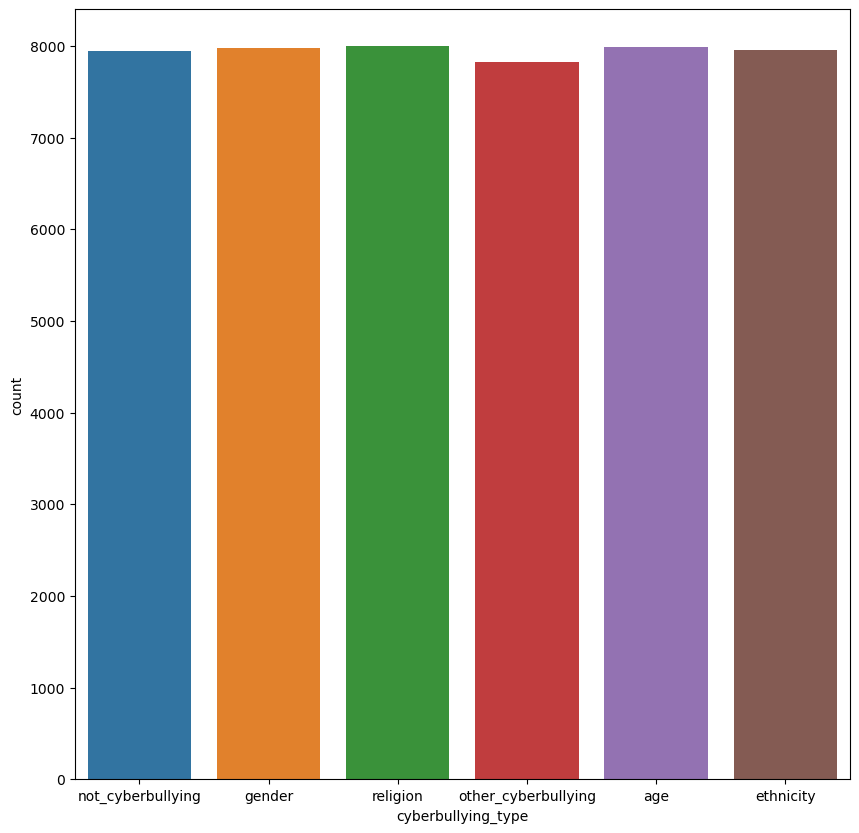

In [8]:
plt.figure(figsize=(10,10))
sns.countplot(x=data['cyberbullying_type'])

In [9]:
data['len'] = data['tweet_text'].apply(lambda x: len(x))

In [10]:
data.head()

,tweet_text,cyberbullying_type,len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103


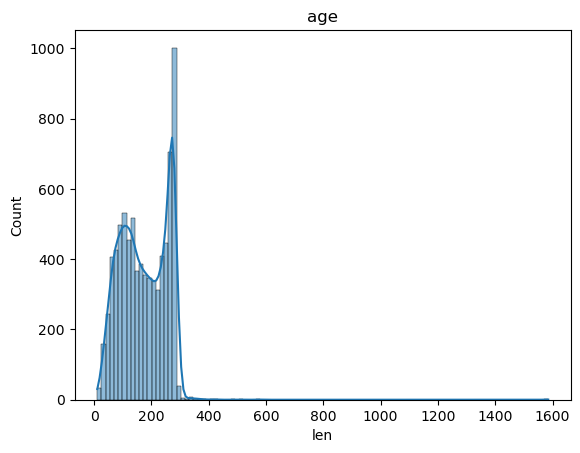

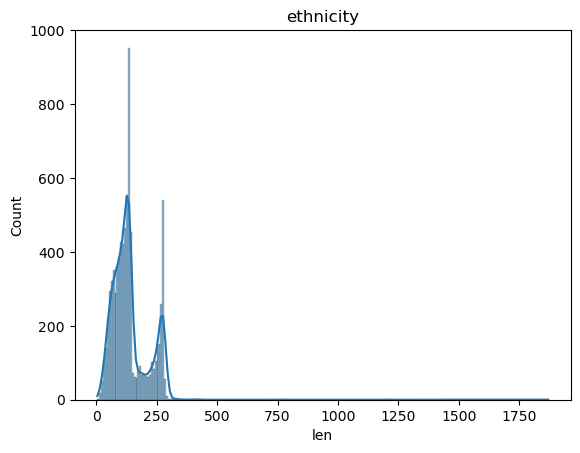

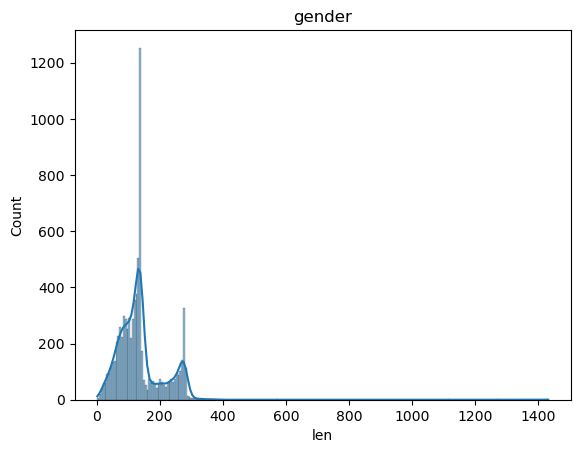

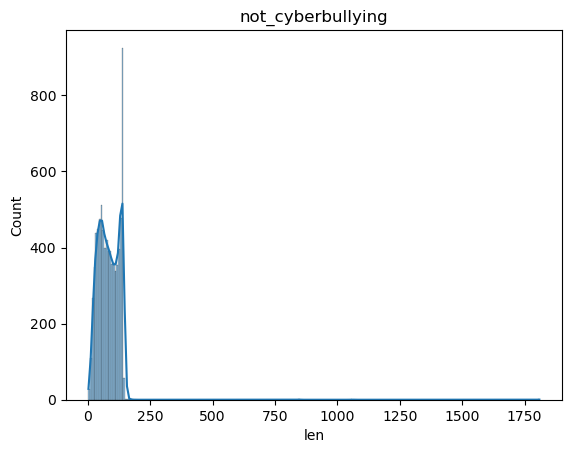

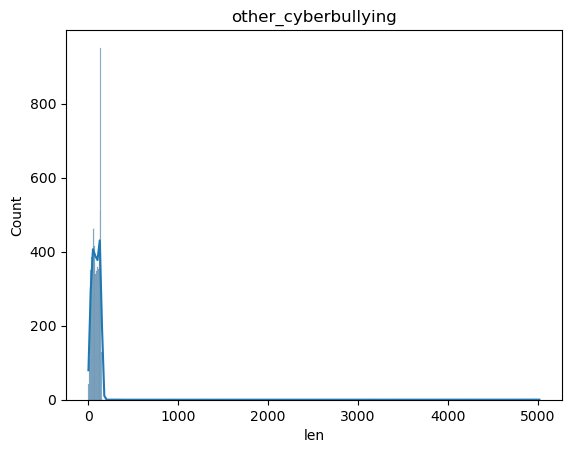

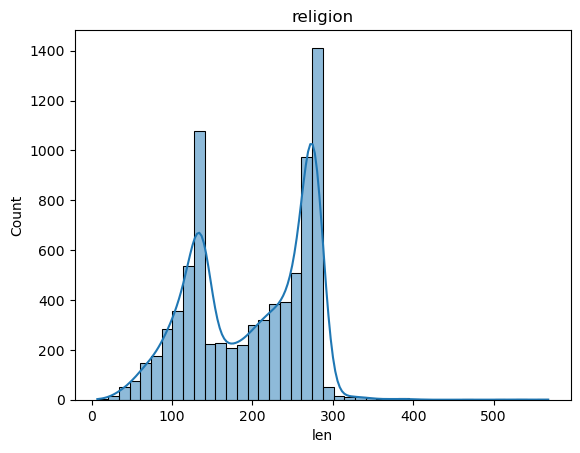

In [21]:
for bullying_type in np.unique(data['cyberbullying_type']):
    bullying_data = data[data['cyberbullying_type']==bullying_type]
    plt.title(f"{bullying_type}")
    sns.histplot(bullying_data['len'],kde=True)
    plt.show()

(0.0, 400.0)

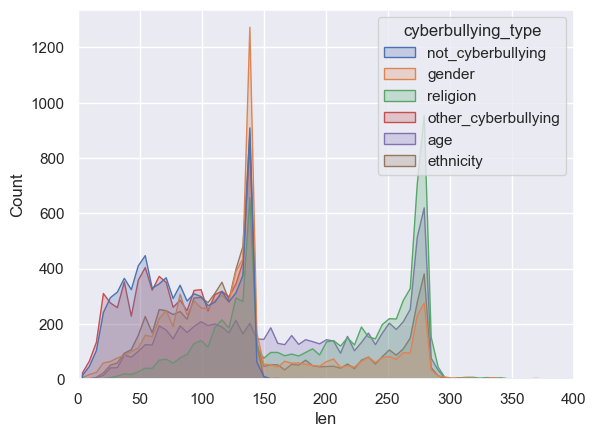

In [36]:
sns.set(style='darkgrid')
sns.histplot(x=data['len'],hue=data['cyberbullying_type'],element='poly')
plt.xlim(0,400)

In [39]:
def generate_word_cloud(text_data,bullying_type):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

    # Create a Seaborn figure
    plt.figure(figsize=(10, 6))
    plt.title(f"{bullying_type}")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    # Display the plot
    plt.show()

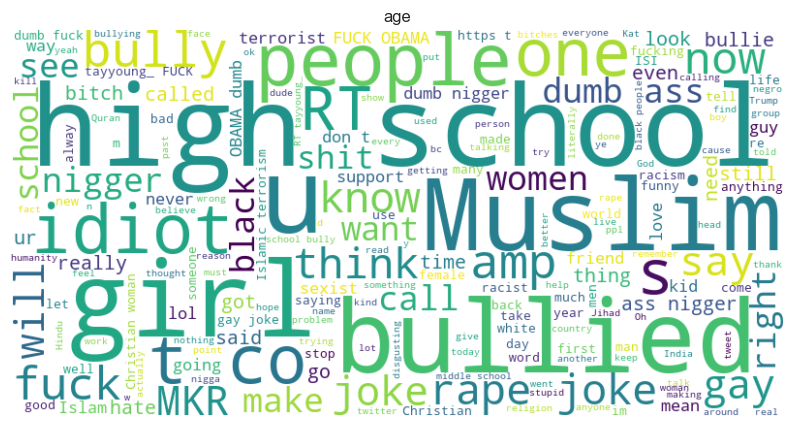

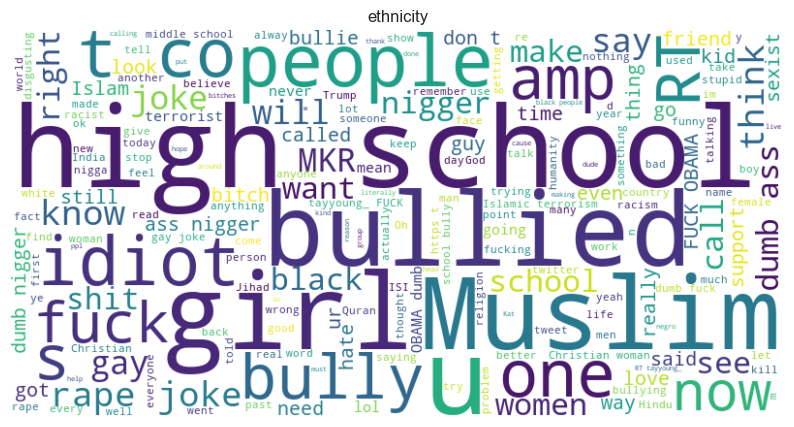

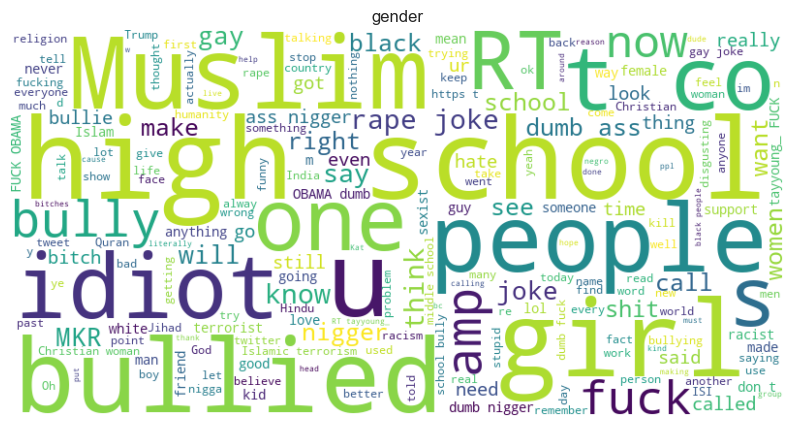

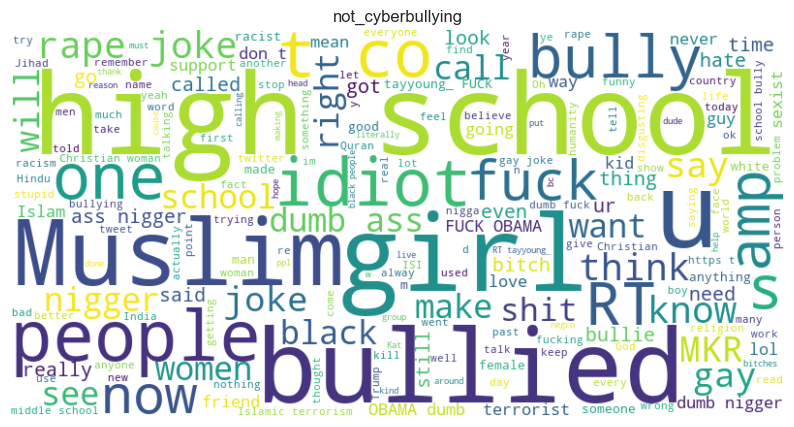

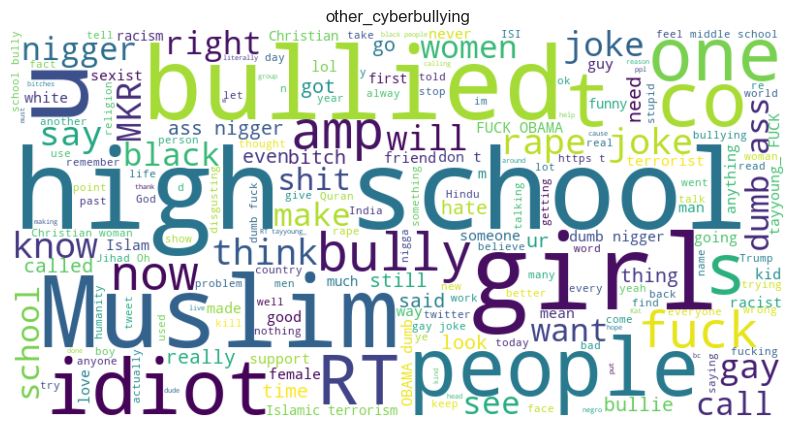

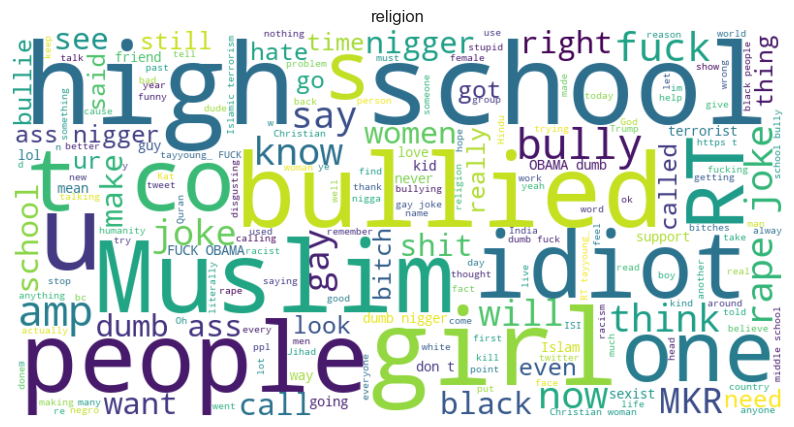

In [40]:
for bullying_type in np.unique(data['cyberbullying_type']):
    bullying_data = bullying_data[bullying_data['cyberbullying_type']==bullying_type]
    text_data = ".".join(data['tweet_text'])
    generate_word_cloud(text_data,bullying_type)

In [75]:
class cleanText:
    """
        Class to help clean the input text by remove hastags,emails,retweets,html,special characters,emojis,punctations 
        from text
        Parameters
        -----------
            texts: array of shape(n_samples,)
        Returns
        -------
            cleaned_texts: array of shape(n_samples,) with cleaned texts
    """
    def __init__(self,texts=None):
        self.texts = texts
        
    def remove_hastags(self,text):
        """
        function to remove hastags from the tweets
        """
        return re.sub(r'#\w*', ' ' , text)

    def remove_urls(self,text):
        """
        function to removes web urls from the tweets
        """
        return re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", '', text)
    
    def remove_email(self,text):
        """
        function to remove email address from tweets
        """
        return re.sub(r'\S+@\S+', '', text)

    def remove_rts(self,text):
        """
        This function removes the retweets from the tweets
        """
        return re.sub(r'@\w+\b',' ',text)

    def remove_special_chars(self,text):
        """
        This function remove any special characters from the tweet
        """
        return re.sub(r"[^a-zA-Z0-9\s]",' ',text)
    
    def tokenize_text(self,text):
        """
        function to tokenizes the input text
        """
        return re.split(r'\s+',text)
    
    def remove_html(self,text):
        """
        function to remove html tags from the tweets
        """
        soup = BeautifulSoup(text, 'lxml')
        text = soup.get_text()
        return text
    
    def decontracted(self,phrase):
        """
        function to expand phrases
        """
        # specific
        phrase = re.sub(r"won\'t", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"\bu\b", "you", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
    
    def convert_to_lowercase(self,tokens):
        """
        function to convert text into lowercase and remove numbers
        """
        return [token.lower() for token in tokens if token.isalpha()]
    
    def remove_single_length_tokens(self,tokens):
        """
        function to remove single character tokens
        """
        return [token for token in tokens if len(token)>1]
    
    def remove_punctuation(self,text):
        """
        function to remove punctuations in text
        """
        return re.sub('['+string.punctuation+']', '', text)
    
    def remove_emojis(self,text):
        reemoji_pattern = re.compile(
            u"(\ud83d[\ude00-\ude4f])|"  # emoticons
            u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
            u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
            u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
            u"(\ud83c[\udde0-\uddff])"  # flags (iOS)
            "+", flags=re.UNICODE)
        return reemoji_pattern.sub(r'',text)
    
        
    def clean_text(self):
        cleaned_texts = []
        for text in tqdm(self.texts):
            text_without_link = self.remove_urls(text)
            text_without_hastags = self.remove_hastags(text_without_link)
            text_without_rts = self.remove_rts(text_without_hastags)
            text_without_email = self.remove_email(text_without_rts)
            text_without_html = self.remove_html(text_without_email)
            text_without_emojis = self.remove_emojis(text_without_html)
            text_without_punct = self.remove_punctuation(text_without_emojis)
            text_decontracted = self.decontracted(text_without_punct)
            text_without_special_chars = self.remove_special_chars(text_decontracted)
            tokens = self.tokenize_text(text_without_special_chars)
            lowercase_tokens = self.convert_to_lowercase(tokens)
            non_single_char_tokens = self.remove_single_length_tokens(lowercase_tokens)
            clean_text = " ".join(non_single_char_tokens)
            cleaned_texts.append(clean_text)
        return cleaned_texts

In [76]:
processText = cleanText(texts=data.tweet_text.values.tolist())
cleanedText = processText.clean_text()

  0%|                                                                                                                                                                                 | 0/47692 [00:00<?, ?it/s]/Users/praveshpradheep/anaconda3/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
 13%|█████████████████████▏                                                                                                                                             | 6211/47692 [00:00<00:03, 10688.57it/s]/Users/praveshpradheep/anaconda3/lib/python3.10/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
100%|███████████████████

In [77]:
data['cleaned_text'] = cleanedText

In [78]:
def plot_most_and_least_freq_words(texts):
    texts = " ".join(texts)
    words = texts.lower().split()
    word_count = collections.Counter(words)
    most_common = word_count.most_common(50)
    least_common = sorted(word_count.items(), key=lambda x: x[1])[:50]
    #plot most common words
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar([word[0] for word in most_common], [word[1] for word in most_common])
    ax.set_title('Top 50 most frequent words')
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()
    #plot least common words
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, prefer_horizontal=0.7).generate_from_frequencies(dict(least_common))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Top 50 least frequent words')
    plt.show()

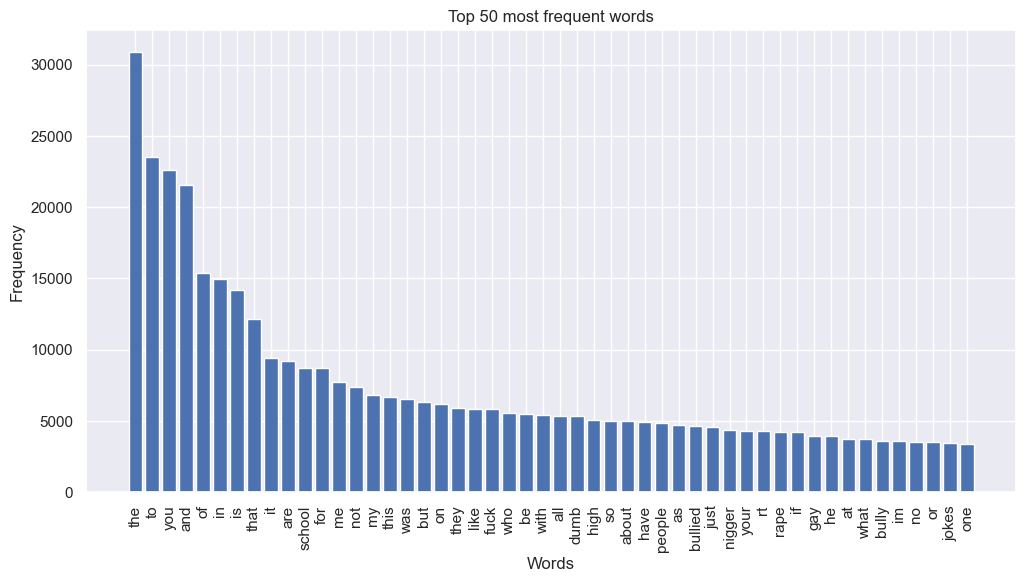

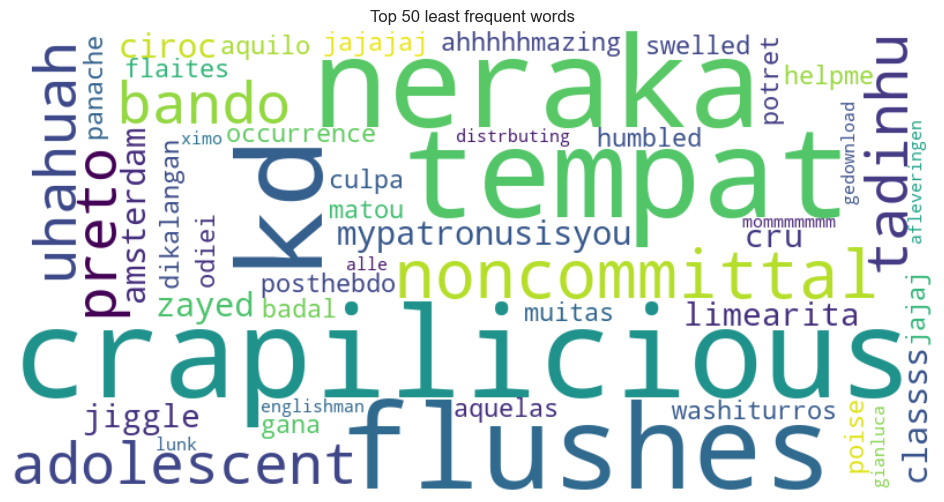

In [79]:
plot_most_and_least_freq_words(cleanedText)

In [80]:
def remove_stop_words(text):
    """
    function to remove stop words from text
    Parameters
    ----------
    text: A single record/line of text
    
    Returns
    -------
    The text after removing all stop words
    """
    tokens = re.split('\s+',text)
    filtered_text = [token for token in tokens if token not in stop_words]
    return " ".join(filtered_text)

def get_lemmatized_text(text):
    """
    function to lemmatize the input text. Lemmatization is the process of breaking down word to it's root form
    Parameters
    ----------
    text: A single record/line of text
    
    Returns
    -------
    The text after applying lemmatization
    
    """
    doc = nlp(text)
    lemmatized_text = [token.lemma_ for token in doc]
    return " ".join(lemmatized_text)

In [81]:
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.STOP_WORDS
stop_words = stop_words.union(set(['amp','rt']))
negative_words = set(['not', 'no', 'don', "don't", 'shouldn', "shouldn't", 'couldn', "couldn't"])
stop_words = stop_words - negative_words

In [82]:
data['cleaned_text'] = data['cleaned_text'].apply(remove_stop_words)
data['cleaned_text'] = data['cleaned_text'].apply(get_lemmatized_text)

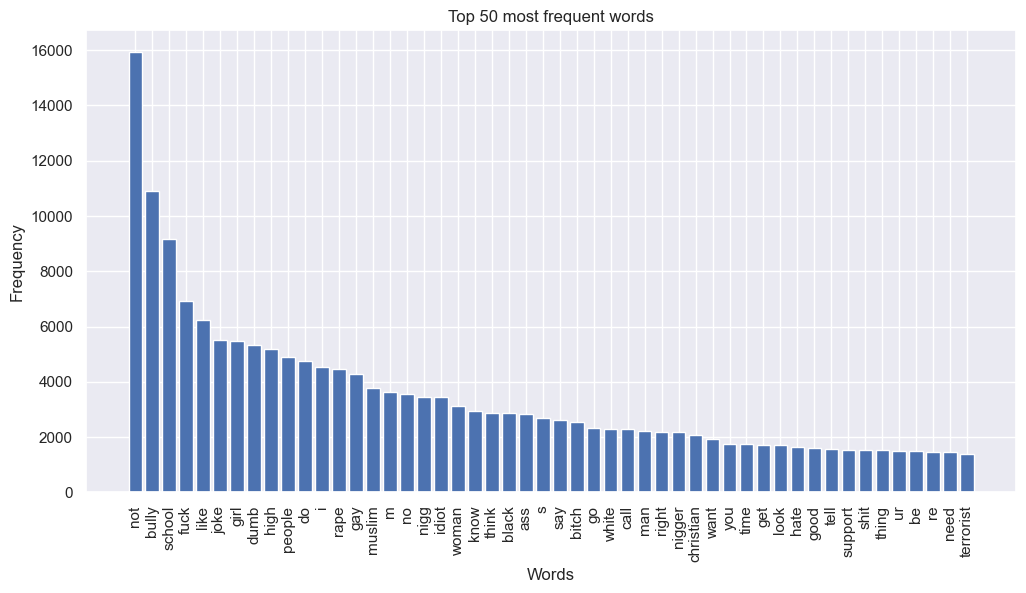

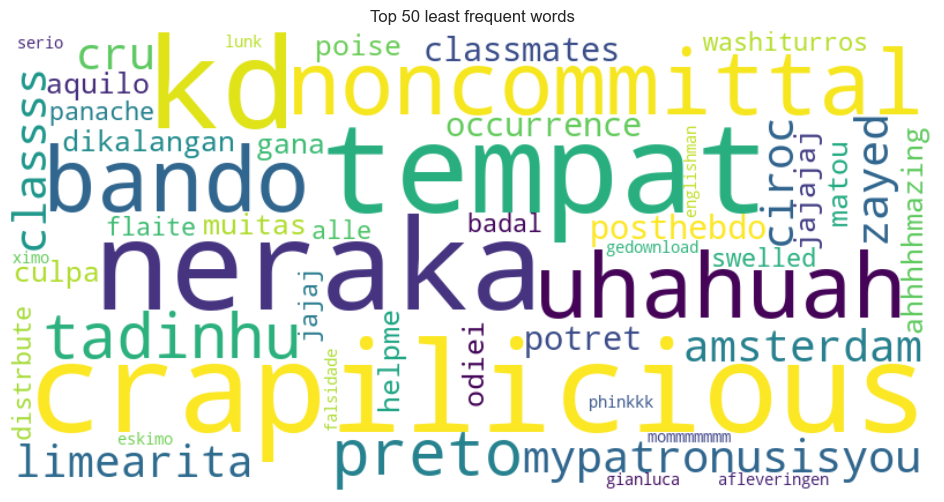

In [83]:
plot_most_and_least_freq_words(data['cleaned_text'].values.tolist())

## TF-IDF Vectorizer

In [89]:
tfidf_vectorizer = TfidfVectorizer(min_df=5,max_df=0.95)

In [90]:
tfidf_vectorizer.fit(list(data['cleaned_text']))

TfidfVectorizer(max_df=0.95, min_df=5)

In [91]:
tfidf_model = tfidf_vectorizer.transform(list(data['cleaned_text']))

In [92]:
print("Number of unique words in the corpus is {}".format(tfidf_model.shape[1]))

Number of unique words in the corpus is 7482


In [100]:
X_train,X_test,y_train,y_test = train_test_split(tfidf_model.tocsr(),
                                                 data['cyberbullying_type'],test_size=0.2,stratify=data['cyberbullying_type'],random_state=42)

In [103]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.20,stratify=y_train,random_state=42)

In [104]:
print("Number of Training samples are: {}".format(X_train.shape[0]))
print("Number of Validation samples are: {}".format(X_val.shape[0]))
print("Number of Testing samples are: {}".format(X_test.shape[0]))

Number of Training samples are: 25944
Number of Validation samples are: 6486
Number of Testing samples are: 9539


In [ ]:
##